In [6]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [8]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [9]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [15]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores

In [16]:
def generate_uniform_circle_data(n, center, radius):
    length = np.sqrt(np.random.uniform(0, 1, n)) * radius
    angle = np.pi * np.random.uniform(
        0, 2, n
    )  # cover full range from 0 to 2pi
    x = length * np.cos(angle) + center[0]
    y = length * np.sin(angle) + center[1]
    return np.vstack((x, y)).T

def get_circle_idx(X, center, radius):
    h, k = center
    idx = np.sqrt((X[:, 0] - h) ** 2 + (X[:, 1] - k) ** 2) < radius
    return idx

def radius_for_lf_metric(target_val, slice_radius, metric=None):
    assert isinstance(slice_radius, int) or isinstance(slice_radius, float)

    if metric == 'recall':
        return np.sqrt(target_val * (slice_radius**2))
    elif metric == 'precision':
        return np.sqrt((slice_radius**2) / target_val)
    else: 
        return slice_radius

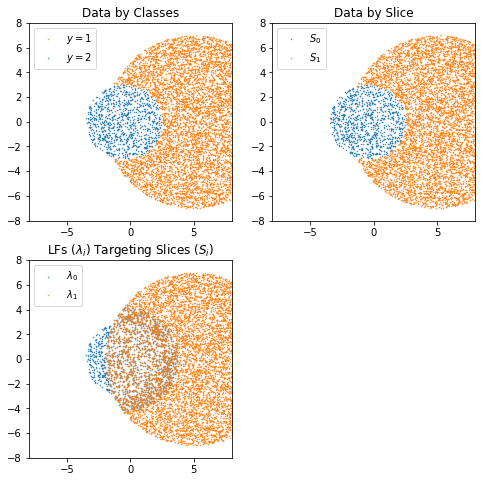

In [17]:
from synthetics_utils import shuffle_matrices, lf_circ_idx_for_slice_precision

config = {
    'N': 10000,
    'mus': np.array([[-0.5,  0], [5, 0]]),
    'variances': [3, 7],
#  'mus': np.array([[0.5,  0], [5, 0]]),
#  'variances': [2.2, 7],
    'labels': [2, 1],
    'props': [0.1, 0.9],
    'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
}

def generate_simple_data(config, x_var=None, x_val=None, verbose=False, return_overlap=False):        
    centers = config['mus']
    radii = config['variances']
    class_props = config['props']
    N = config['N']
    labels = config['labels']
    lf_metrics = config['lf_metrics']    

    # overwrite recall value for head lf
    if x_var == 'slice_proportion': # slice proportion
        class_props[0] = x_val
        class_props[1] = 1 - x_val
        
    elif x_var == 'head_recall':
        target_metric = 'recall'
        lf_metrics[0] = ('recall', x_val)        
        
    # override head precision value
#     head_precision_override = None
    if x_var == 'head_precision':
        target_metric = 'precision'
#         head_precision_override = x_val
        lf_metrics[0] = ('precision', x_val)
    
    # Set slice 1
    n_per_slice = [int(N*prop) for prop in class_props]
    slice_1 = generate_uniform_circle_data(
        n_per_slice[1], 
        centers[1], 
        radii[1]
    )

    # get idx for slice 0 within slice 1
    slice_0_idx = get_circle_idx(slice_1, tuple(centers[0]), radii[0])
    
    # remove slice 0 idx from slice 1
    # NOTE: because we remove the slice, if the variances are not 
    # proportional to the slice size, the original props will not be maintained
    slice_1 = slice_1[np.logical_not(slice_0_idx)]
    n_per_slice[1] = len(slice_1)

    # Set slice 0
    slice_0 = generate_uniform_circle_data(
        n_per_slice[0], 
        centers[0], 
        radii[0]
    )

    # combine slices
    Xu = [slice_0, slice_1] # data points
    Yu = [label * np.ones(n) for n, label in zip(n_per_slice, labels)] # class labels
    Cu = [i * np.ones(n) for i, n in enumerate(n_per_slice)] # slice labels

    X, Y, C = shuffle_matrices([np.vstack(Xu), np.hstack(Yu), np.hstack(Cu)])
    
    # generate label matrix
    L = np.zeros((sum(n_per_slice), 2))

    # set LF0 to target slice 0
    lf0_target_metric, lf0_target_value = lf_metrics[0]
    lf_0_idx = get_circle_idx(
        X, 
        tuple(centers[0]), 
        radius_for_lf_metric(lf0_target_value, radii[0], metric=lf0_target_metric)
    )
    
#     if head_precision_override:
#         lf_0_idx = lf_circ_idx_for_slice_precision(
#             x_val, X, C==0, tuple(centers[0]), radii[0], verbose=True
#         )
    
    L[lf_0_idx, 0] = labels[0]
    
    # set LF1 to target slice 1
    lf1_target_metric, lf1_target_value = lf_metrics[1]
    lf_1_idx = get_circle_idx(
        X, 
        tuple(centers[1]), 
        radius_for_lf_metric(lf1_target_value, radii[1], metric=lf1_target_metric)
    )
    
    L[lf_1_idx, 1] = labels[1]

    overlap_idx = np.logical_and(lf_0_idx, lf_1_idx)
    
    if return_overlap:
        return X, Y, C, L, overlap_idx
    
    return X, Y, C, L

X, Y, C, L, overlap_idx = generate_simple_data(
    config,
    x_var='head_precision',
    x_val=0.5,
    return_overlap=True
)

# mask = C==1
mask = overlap_idx
# X = X[mask]
# Y = Y[mask]
# L = L[mask]
# C = C[mask]

visualize_data(X, Y, C, L)

In [18]:
np.unique(L, return_counts=True), np.unique(Y, return_counts=True)

((array([0., 1., 2.]), array([7056, 8491, 1945])),
 (array([1., 2.]), array([7746, 1000])))

In [19]:
np.unique(L.sum(axis=1), return_counts=True)

(array([1., 2., 3.]), array([6801,  255, 1690]))

In [20]:
X = torch.from_numpy(X.astype(np.float32))

In [21]:
from simulate import simulate, experiment_config
train_end_idx = int(len(X) * experiment_config["train_prop"])
dev_end_idx = train_end_idx + int(len(X) * experiment_config["dev_prop"])

L = L.astype(np.float32)
Y = Y.astype(np.float32)
X_train, X_dev, X_test = X[:train_end_idx], X[train_end_idx:dev_end_idx], X[dev_end_idx:]
Y_train, Y_dev, Y_test = Y[:train_end_idx], Y[train_end_idx:dev_end_idx], Y[dev_end_idx:]
C_train, C_dev, C_test = C[:train_end_idx], C[train_end_idx:dev_end_idx], C[dev_end_idx:]
L_train, L_dev, L_test = L[:train_end_idx], L[train_end_idx:dev_end_idx], L[dev_end_idx:]

overlap_train, overlap_dev, overlap_test = overlap_idx[:train_end_idx], overlap_idx[train_end_idx:dev_end_idx], overlap_idx[dev_end_idx:]

[0.5081967213114754, 0.9209905660377359]


(array([ 190.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 5932.]),
 array([0.48361096, 0.50058041, 0.51754985, 0.53451929, 0.55148874,
        0.56845818, 0.58542763, 0.60239707, 0.61936651, 0.63633596,
        0.6533054 , 0.67027484, 0.68724429, 0.70421373, 0.72118318,
        0.73815262, 0.75512206, 0.77209151, 0.78906095, 0.8060304 ,
        0.82299984, 0.83996928, 0.85693873, 0.87390817, 0.89087762,
        0.90784706, 0.9248165 , 0.94178595, 0.95875539, 0.97572484,
        0.99269428]),
 <a list of 30 Patch objects>)

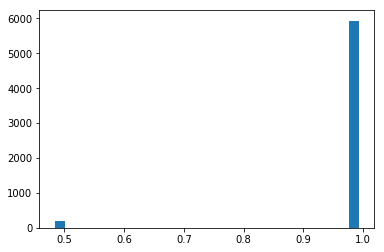

In [22]:
from metal.contrib.slicing.experiment_utils \
    import compute_lf_accuracies
accs = compute_lf_accuracies(L_dev, Y_dev)
print (accs)

# accs = np.array([0.9, 0.1]).astype(np.float32)
from metal.contrib.slicing.experiment_utils import generate_weak_labels
Y_tilde_accs = generate_weak_labels(L_train, np.array(accs))
plt.hist(Y_tilde_accs[:, 0], 30)

(array([ 190.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1190.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 4742.]),
 array([0.31447694, 0.32341508, 0.33235322, 0.34129136, 0.35022949,
        0.35916763, 0.36810577, 0.37704391, 0.38598204, 0.39492018,
        0.40385832, 0.41279645, 0.42173459, 0.43067273, 0.43961087,
        0.448549  , 0.45748714, 0.46642528, 0.47536342, 0.48430155,
        0.49323969, 0.50217783, 0.51111596, 0.5200541 , 0.52899224,
        0.53793038, 0.54686851, 0.55580665, 0.56474479, 0.57368293,
        0.58262106]),
 <a list of 30 Patch objects>)

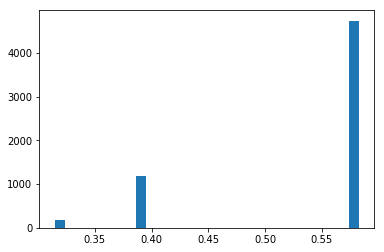

In [23]:
Y_tilde_metal = generate_weak_labels(L_train)
plt.hist(Y_tilde_metal[:, 0], 30)

### Validating that we can reproduce the L matrix 
Train attention model with `slice_weight=1.0`. Then, try to repredict the `L_test` values using the `L_head`.

In [24]:
from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

model_configs = {
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 1.0, # NOTE: slice weight 1.0 means we are only backprop on L_head
            "L_weights": None
        },
#         "input_module_class": LinearModule,
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

In [ ]:
from simulate import train_models

# DEBUG: gt labels for training [prob_1, prob2]
Y_cat = np.zeros((Y_train.shape[0], 2))
Y_cat[:,0] = Y_train == 1
Y_cat[:,1] = Y_train == 2
Y_cat = Y_cat.astype(np.float32)

config['accs'] = np.array(accs)
# config['accs'] = np.array([1.0, 1.0])
experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = None
experiment_config['num_trials'] = 1
experiment_config['verbose'] = True
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 20
experiment_config['seed'] = 222

trained_models = train_models(
    X_train,
    L_train,
    Y_tilde_accs,
    (X_test, Y_test),
    model_configs,
    experiment_config["train_kwargs"],
    verbose=experiment_config["verbose"],
    seed=experiment_config.get("seed", None)
)


In [ ]:
from metal.metrics import accuracy_score
import torch.nn.functional as F
# X_test_L_head = X_train
# L_test_L_head = L_train
# overlap_test_L_head = overlap_train

X_test_L_head = X_test
L_test_L_head = L_test
overlap_test_L_head = overlap_test


slice_preds = F.sigmoid(
    trained_models['AttentionModel'].forward_L(X_test_L_head)
).detach().numpy()


preds = (slice_preds > 0.5) * 1
L_gt = L_test_L_head.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.sum(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))

print ('accuracy over overlap for LF 0:', 
       accuracy_score(L_gt[overlap_test_L_head, 0], preds[overlap_test_L_head, 0]))

print ('accuracy over overlap for LF 1:', 
      accuracy_score(L_gt[overlap_test_L_head, 1], preds[overlap_test_L_head, 1]))


### Compare EndModel to AttentionModel

In [45]:
model_configs = {
    "EndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False
    },
    "UpsampledEndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False,
        "upsample_lf0": True
    },
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 0.1,
            "L_weights": None
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

Simulating: head_recall=0.9


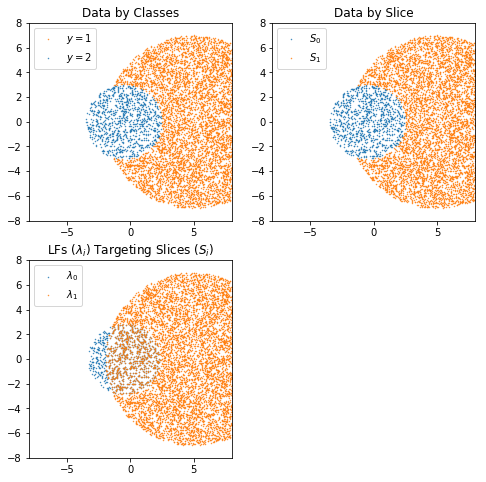

defaultdict(<function simulate.simulate.<locals>.<lambda>()>,
            {'EndModel': defaultdict(list,
                         {0.9: [{'S0': 0.7621621621621621,
                            'S1': 0.9993573264781491,
                            'overall': 0.974152785755313}]}),
             'UpsampledEndModel': defaultdict(list,
                         {0.9: [{'S0': 0.8648648648648649,
                            'S1': 0.9974293059125964,
                            'overall': 0.9833429063756461}]}),
             'AttentionModel': defaultdict(list,
                         {0.9: [{'S0': 0.8486486486486486,
                            'S1': 0.9987146529562982,
                            'overall': 0.9827685238368754}]})})

In [46]:
from simulate import simulate, experiment_config
config['accs'] = np.array(accs)
experiment_config['use_weak_labels_from_gen_model'] = False
# experiment_config['x_var'] = None
experiment_config['x_var'] = 'head_recall'
# experiment_config['x_range'] = np.linspace(0, 1, 10)
experiment_config['x_range'] = [0.9]
experiment_config['num_trials'] = 1 
experiment_config['verbose'] = False
experiment_config['visualize_data'] = True
experiment_config['traign_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 40
experiment_config['plot_predictions'] = None

experiment_config['seed'] = 111
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

## Vary Head LF Recall

Simulating: head_recall=0.9


[autoreload of simulate failed: Traceback (most recent call last):
  File "/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>

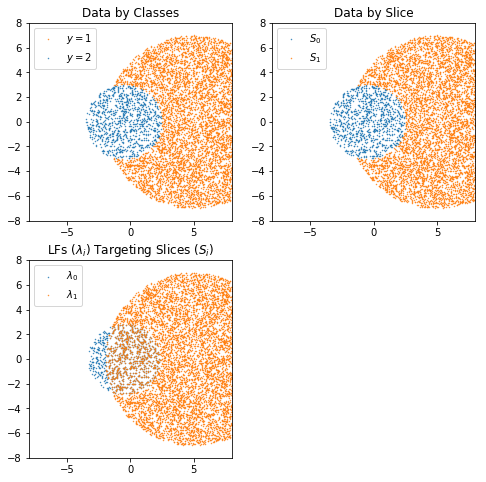

KeyboardInterrupt: 

In [43]:
from simulate import simulate, experiment_config
config['accs'] = np.array(accs)
experiment_config['use_weak_labels_from_gen_model'] = False
# experiment_config['x_var'] = None
experiment_config['x_var'] = 'head_recall'
# experiment_config['x_range'] = np.linspace(0, 1, 10)
experiment_config['x_range'] = [0.9]
experiment_config['num_trials'] = 1 
experiment_config['verbose'] = False
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 40
experiment_config['plot_predictions'] = ['EndModel', 'AttentionModel']

experiment_config['seed'] = 111
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

In [ ]:
plot_slice_scores(scores, xlabel="Head LF Recall", custom_ylims={'S1': [0.95, 1.05]})

## Vary Head LF Precision

In [ ]:
experiment_config['num_trials'] = 5
experiment_config['x_var'] = 'head_precision'
experiment_config['x_range'] = np.linspace(0.5, 1, 10)
experiment_config['plot_predictions'] = ['EndModel', 'AttentionModel']

scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

In [ ]:
plot_slice_scores(scores, xlabel="Head LF Precision", 
                  custom_ylims={'S0': [0.90, 1.05],
                                'S1': [0.90, 1.05]})

## Vary Slice Proportion

In [ ]:
experiment_config['num_trials'] = 5 
experiment_config['x_var'] = 'slice_proportion'
experiment_config['x_range'] = np.linspace(0.01, 0.3, 10)
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

In [ ]:
plot_slice_scores(scores, xlabel="Slice Proportion", custom_ylims={'S1': [0.95, 1.05]})